In [3]:
! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.22) to /tmp/pip-install-bgiteznw/granite-tsfm_1206f5bb74e14cada840c1b6b7e3c381
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-bgiteznw/granite-tsfm_1206f5bb74e14cada840c1b6b7e3c381
  Running command git checkout -q 216850d0cb073e31689049c1334f701fe11bc2c3
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit 216850d0cb073e31689049c1334f701fe11bc2c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
!pip install --upgrade numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 52.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
granite-tsfm 0.2.22 requires numpy<2, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.


In [7]:
!pip install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 90.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.48.3
    Uninstalling transformers-4.48.3:
      Successfully uninstalled transformers-4.48.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
granite-tsfm 0.2.22 requires numpy<2, but you have numpy 2.2.4 which is incompatible.


In [1]:
import os
import tempfile

from transformers import Trainer, TrainingArguments, set_seed

from tsfm_public import TinyTimeMixerForPrediction, load_dataset
from tsfm_public.toolkit import RecursivePredictor, RecursivePredictorConfig
from tsfm_public.toolkit.visualization import plot_predictions

In [2]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# DATA ROOT PATH
# Make sure to download the target data (here ettm2) on the `DATA_ROOT_PATH` folder.
# ETT is available at: https://github.com/zhouhaoyi/ETDataset/tree/main
target_dataset = "etth1"

dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"

# DATA_ROOT_PATH = "/dccstor/tsfm23/datasets/"

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

ROLLING_PREDICTION_LENGTH = 192
TTM_MODEL_URL = (
    "ibm-granite/granite-timeseries-ttm-v1"  # POINT TO A ZEROSHOT MODEL OR A FINETUNED MODEL TO DO ROLLING INFERENCE.
)

In [3]:
base_model = TinyTimeMixerForPrediction.from_pretrained(TTM_MODEL_URL, revision=TTM_MODEL_REVISION)

base_model_context_length = base_model.config.context_length
base_model_prediction_length = base_model.config.prediction_length

print(base_model_context_length, base_model_prediction_length)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.24M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

512 96


In [4]:
_, _, dset_test = load_dataset(
    dataset_name=target_dataset,
    context_length=base_model_context_length,
    forecast_length=ROLLING_PREDICTION_LENGTH,
    fewshot_fraction=1.0,
    dataset_path=dataset_path,
)

In [5]:
rec_config = RecursivePredictorConfig(
    model=base_model,
    requested_prediction_length=ROLLING_PREDICTION_LENGTH,
    model_prediction_length=base_model_prediction_length,
    loss=base_model.config.loss,
)
rolling_model = RecursivePredictor(rec_config)

In [6]:
temp_dir = tempfile.mkdtemp()
# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=rolling_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=32,
        seed=SEED,
    ),
)
# evaluate = zero-shot performance
print("+" * 20, "Test MSE zero-shot", "+" * 20)
zeroshot_output = zeroshot_trainer.evaluate(dset_test)
print(zeroshot_output)

++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zl3340 (zl3340-columbia-university-in-the-city-of-new-york) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


{'eval_loss': 0.3921540379524231, 'eval_model_preparation_time': 0.003, 'eval_runtime': 31.0959, 'eval_samples_per_second': 86.474, 'eval_steps_per_second': 2.733}


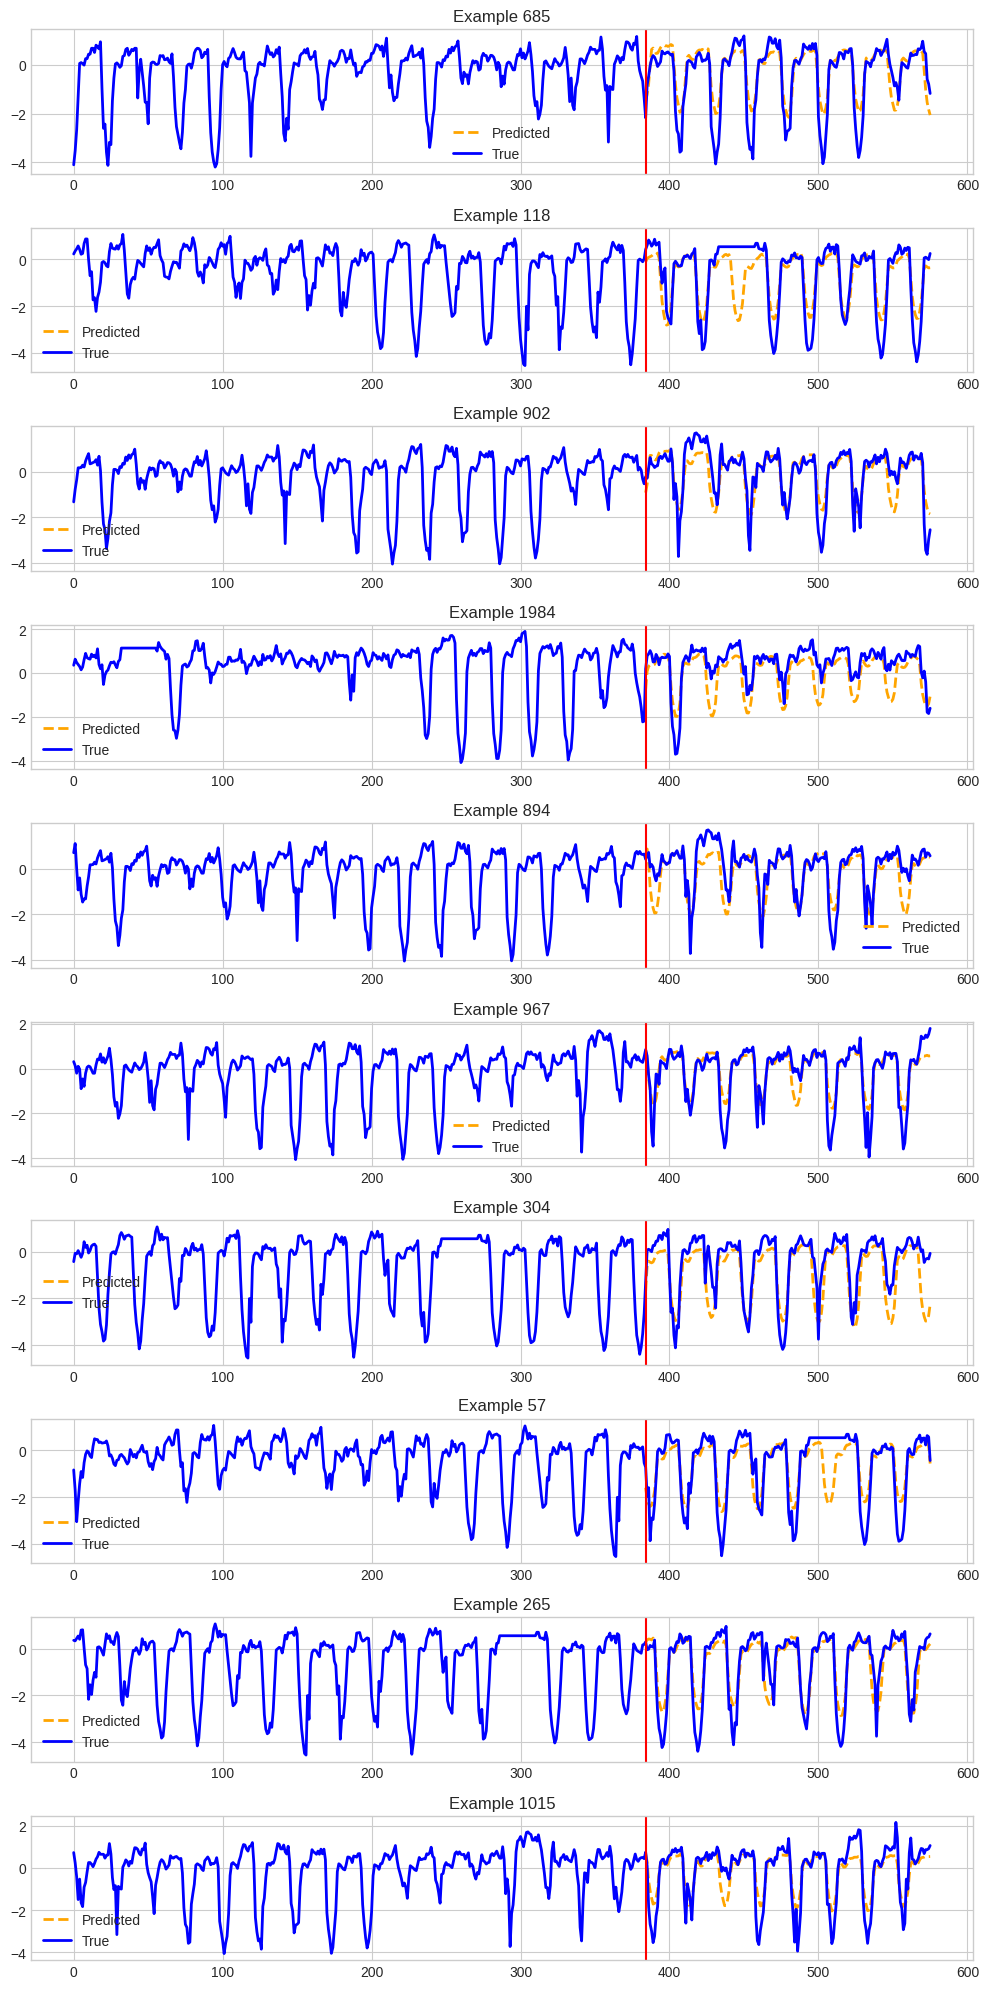

In [7]:
plot_predictions(
    model=zeroshot_trainer.model,
    dset=dset_test,
    plot_dir=os.path.join(OUT_DIR, target_dataset),
    plot_prefix="test_rolling",
    indices=[685, 118, 902, 1984, 894, 967, 304, 57, 265, 1015],
    channel=0,
)